In [1]:
import rioxarray
import xarray

xds = xarray.open_dataset("ETOPO2v2c_f4.nc")

In [2]:
xds

<xarray.Dataset> Size: 233MB
Dimensions:  (x: 10800, y: 5400)
Coordinates:
  * x        (x) float32 43kB -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
  * y        (y) float32 22kB -89.98 -89.95 -89.92 -89.88 ... 89.92 89.95 89.98
Data variables:
    z        (y, x) float32 233MB ...
Attributes:
    Conventions:  COARDS
    title:        
    source:                               -Rd -I2m -ZTLf                     ...
    node_offset:  1

In [4]:
xds["z"].rio.to_raster("world_elevation.tif")

In [16]:
import pandas as pd
import geopandas as gpd
import geodatasets
import h3pandas
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import tskit
import tszip
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/terracotta")
import terracotta as tct
import importlib
importlib.reload(tct)
import time
import xarray
import rioxarray
import rasterstats
import rasterio
import matplotlib.pyplot as plt

/opt/anaconda3/envs/terracotta/lib/python3.12/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


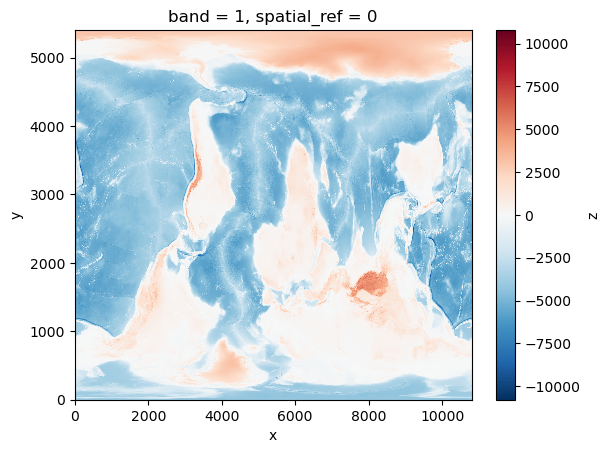

In [2]:
elev = rioxarray.open_rasterio("ETOPO2v2c_f4.nc")
elev = elev.rio.write_crs("epsg:4326")
elev.plot()

In [24]:
elev = xarray.open_dataset("ETOPO2v2c_f4.nc")
rasterstats.zonal_stats(gdf_h3, elev.read(1), affine=elev.rio.transform)

AttributeError: 'Dataset' object has no attribute 'read'

In [34]:
gdf = gpd.read_file(geodatasets.get_url("naturalearth land"))
gdf = gdf.loc[112:112]

#elev = xarray.open_dataset("ETOPO2v2c_f4.nc")
#elev.z.plot(x="x", y="y")

<Axes: >

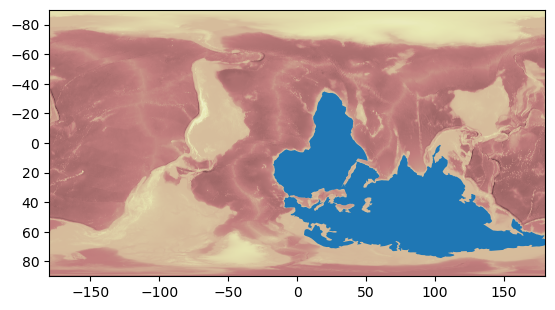

In [25]:
from rasterio.plot import show

elev = rasterio.open("world_elevation.tif")

fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent = [elev.bounds[0], elev.bounds[2], elev.bounds[1], elev.bounds[3]]
ax = rasterio.plot.show(elev, extent=extent, ax=ax, cmap="pink")

gdf.plot(ax=ax)

In [100]:
resolution = 2
gdf_h3 = gdf.h3.polyfill_resample(resolution)
gdf_h3 = gdf_h3.reset_index()
gdf_h3["deme"] = gdf_h3.index

<Axes: >

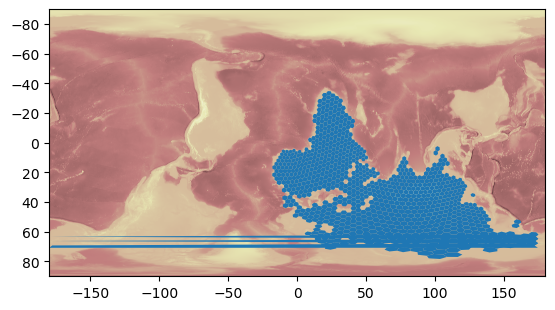

In [27]:
fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent = [elev.bounds[0], elev.bounds[2], elev.bounds[1], elev.bounds[3]]
ax = rasterio.plot.show(elev, extent=extent, ax=ax, cmap="pink")

gdf_h3.plot(ax=ax)

In [53]:
rasterstats.zonal_stats(gdf_h3, elev.read(1), affine=elev.rio.transform)

AttributeError: 'DatasetReader' object has no attribute 'rio'

In [62]:
elev = rasterio.open("netcdf:ETOPO2v2c_f4.nc:z")
print(elev.read(1))

[[-4119. -4119. -4119. ... -4119. -4119. -4119.]
 [-4117. -4117. -4117. ... -4117. -4117. -4117.]
 [-4113. -4113. -4113. ... -4113. -4113. -4113.]
 ...
 [ 2772.  2772.  2772. ...  2772.  2772.  2772.]
 [ 2772.  2772.  2772. ...  2774.  2774.  2774.]
 [ 2774.  2774.  2774. ...  2774.  2774.  2776.]]


In [69]:
gdf = gpd.read_file(geodatasets.get_url("naturalearth land"))
gdf = gdf.loc[112:112]
gdf.total_bounds

array([-17.625     , -34.8190918 , 180.        ,  77.69787598])

<Axes: >

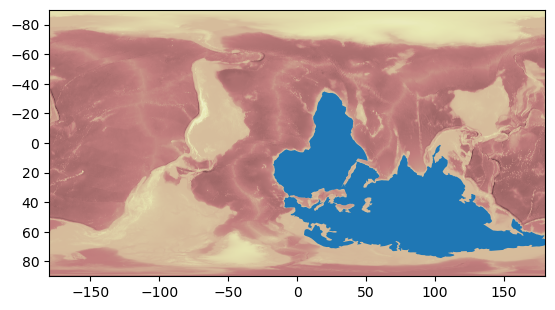

In [72]:
from rasterio.plot import show

elev = rasterio.open("world_elevation.tif")

fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent = [gdf.total_bounds[0], gdf.total_bounds[1], gdf.total_bounds[2], gdf.total_bounds[3]]
ax = rasterio.plot.show(elev, extent=extent, ax=ax, cmap="pink")

gdf.plot(ax=ax)

In [114]:
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio import transform
from rasterio.plot import show

with rasterio.open("world_elevation.tif") as src_dst:
    with WarpedVRT(
        src_dst,
        src_crs=src_dst.gcps[1],
        src_transform=transform.from_gcps(src_dst.gcps[0]),
    ) as vrt:
        mean_elev = []
        for stat in rasterstats.zonal_stats(
            gdf_h3,
            vrt.read(1),
            affine=vrt.transform,
            stats="mean"
        ):
            mean_elev.append(stat["mean"])
        gdf_h3["mean_elev"] = mean_elev

<Axes: >

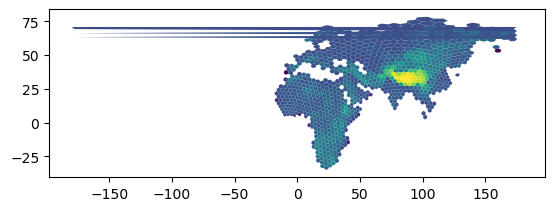

In [115]:
gdf_h3.plot(column="mean_elev")